# Anomaly Detection with the Local Outlier Factor

The **Local Outlier Factor (LOF)** is a density-based anomaly detection algorithm that quantifies how isolated each data point is relative to its local neighborhood.
Instead of applying a single global distance threshold, LOF estimates the **local density** around every sample and compares it with the densities of its nearest neighbors.
Points located in regions that are substantially less dense than those of their neighbors are considered potential outliers.


This localized approach makes LOF particularly effective for datasets with **non-uniform density**, where clusters vary in compactness or spread.
The algorithm produces a **LOF score** for each sample, which can be interpreted as follows:


- **LOF < 1:** The sample lies in a denser region than its neighbors (potentially part of a very compact cluster).
- **LOF ≈ 1:** The sample has a density comparable to its neighbors and is considered *normal*.
- **LOF >> 1:** The sample resides in a region of much lower density and is likely an *outlier*.


In this way, LOF captures *relative density deviations* rather than assuming a single global notion of normality, enabling robust detection of local anomalies in complex datasets.


This notebook shows how to:
1. Generate a small synthetic dataset with normal points and outliers.
2. Apply Heat’s distributed LOF implementation.
3. Visualize and interpret the resulting anomaly scores.

In [62]:
import heat as ht
import numpy as np
import torch
from heat.classification.localoutlierfactor import LocalOutlierFactor
from mpi4py import MPI
import matplotlib.pyplot as plt

# Uncomment the following line to enable GPU usage if necessary
# ht.use_device("gpu")

print(f"Running on device: {ht.get_device()}")
print(f"MPI world size: {ht.MPI_WORLD.size}")

Running on device: gpu:0
MPI world size: 1


### About the setup

The code below initializes all required modules:
- **Heat (ht)** for distributed array operations
- **NumPy** for basic data generation
- **Matplotlib** for visualization

> 💡 You can uncomment `ht.use_device("gpu")` to run this example on a GPU if available.

## Step 1: Generate synthetic data

To illustrate the LOF algorithm, we will create a small two-dimensional dataset.
It consists of two dense clusters of points and a few uniformly distributed **outliers**.

In [63]:
def generate_test_data(random_seed:int = 42, points: int = 100, outliers: int = 20):
    np.random.seed(random_seed)

    # Generate two Gaussian clusters
    X_inliers = 0.3 * np.random.randn(points, 2)
    X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

    # Add uniformly distributed outliers
    X_outliers = np.random.uniform(low=-4, high=4, size=(outliers, 2))
    X = np.r_[X_outliers, X_inliers]

    # Convert to Heat tensor (distributed array)
    ht_X = ht.array(X, split=0)
    return ht_X

ht_data = generate_test_data()
data = ht_data.numpy()
print(f"Generated dataset with shape: {ht_data.shape}")

Generated dataset with shape: (220, 2)


> 🔍 The dataset contains 220 samples in total: 200 inliers forming two clusters and 20 outliers scattered randomly.

## Step 2: Compute Local Outlier Factor

We now fit the LOF model to the generated data.

The current implementation allows for adjusting two parameters:
- **`n_neighbors`**: number of neighboring points used to estimate local density.
- **`threshold`**: points with a higher LOF score thean thus cut-off value are labeled as anomalies.

The Heat implementation distributes both the neighbor search and LOF computation across all available MPI processes.

In [64]:
lof = LocalOutlierFactor(n_neighbors=10, threshold=2)
lof.fit(ht_data)

lof_scores = lof.lof_scores.numpy()
anomaly = lof.anomaly.numpy()
print(f"Computed LOF scores. Number of detected outliers: {np.sum(np.where(anomaly==-1, 0, 1))}")

Computed LOF scores. Number of detected outliers: 18


After fitting, each point receives a **LOF score**:
- Values around **1** correspond to normal points (similar local density).
- Values significantly larger than **1** indicate potential outliers.

The `threshold` parameter determines which points are finally classified as anomalies.

## Step 3: Visualize LOF scores

The plot below shows the data points colored by their LOF scores.
- The color intensity represents how “different” a point’s local density is compared to its neighbors.
- Points outlined with a black circle are flagged as **outliers**.

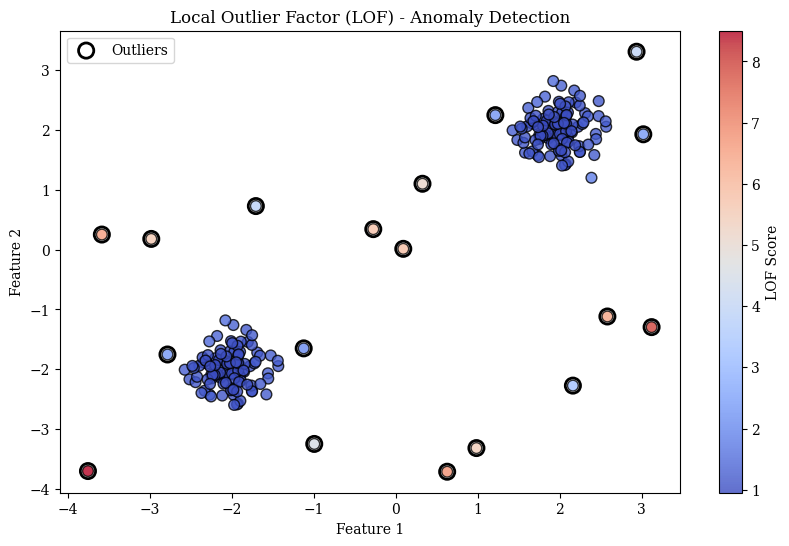

In [65]:
def plot_lof(data: np.array, lof_scores: np.array, anomaly: np.array): 
    plt.rc("font", family="serif")
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        data[:, 0], data[:, 1], c=lof_scores, cmap="coolwarm", edgecolors="k", s=60, alpha=0.8
    )

    outlier_indices = np.where(anomaly == 1)[0]

    plt.scatter(
        data[outlier_indices, 0],
        data[outlier_indices, 1],
        facecolors="none",
        edgecolors="black",
        s=120,
        linewidths=2,
        label="Outliers",
    )

    plt.colorbar(scatter, label="LOF Score")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Local Outlier Factor (LOF) - Anomaly Detection")
    plt.legend()
    if ht.MPI_WORLD.rank == 0:
        plt.show()

plot_lof(data, lof_scores, anomaly)

> 💡 Interpretation: Points with darker (red) colors have higher LOF scores and are more likely to be outliers. The black-circled points are those identified as anomalies according to the chosen threshold.